# Emotion recognition- RAVDESS dataset

In [ ]:
# https://sail.usc.edu/iemocap/

## Import libraries

In [ ]:
import os
import librosa
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import IPython.display as ipd
import librosa.display
import numpy as np
import cv2 as cv

## Import data from the files

In [ ]:
X, sr = librosa.load('d://ITC/final_project//data//data//Actor_01//03-01-01-01-02-01-01.wav', res_type='kaiser_fast')
X2, sr2 = librosa.load('d://ITC/final_project//data//data//Actor_01//03-01-01-01-02-02-01.wav', res_type='kaiser_fast')
mfcc = librosa.feature.mfcc(y=X, n_fft=2048, hop_length = 512, sr=sample_rate, fmin=145, fmax=155)
X.shape, X2.shape

((72102,), (69895,))

In [ ]:
X = X[:69895]
print(X2.shape, X.shape)
mfcc = librosa.feature.mfcc(y=X, n_fft=2048, hop_length = 512, sr=sr)
mfcc2 = librosa.feature.mfcc(y=X2, n_fft=2048, hop_length = 512, sr=sr2)
mfcc.shape, mfcc2.shape

(69895,) (69895,)


((20, 137), (20, 137))

In [ ]:
S = librosa.feature.melspectrogram(X, sample_rate)
mfcc = librosa.feature.mfcc(X, sample_rate, n_mfcc=40)

S.shape, mfcc.shape

((128, 141), (40, 141))

### Extract data from folder, and get our MFCC's for future classification:

In [ ]:
lst = []
y = []
path = 'D://ITC//final_project//data'
emotion = []
voc_channel = []
full_path = []
modality = []
intensity = []
actors = []
phrase =[]

for root, dirs, files in tqdm(os.walk(path)):
    for file in files:
        try:
            #Load librosa array, obtain mfcss, store the file and the mfcss information in a new array
            X, sr = librosa.load(os.path.join(root,file), res_type='kaiser_fast')
            # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
            # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
            modal = int(file[1:2])
            vchan = int(file[4:5])
            lab = int(file[7:8]) - 1
            ints = int(file[10:11])
            phr = int(file[13:14])
            act = int(file[19:20])

            lst.append([X, sr])
            y.append(lab)

            modality.append(modal)
            voc_channel.append(vchan)
            emotion.append(lab) #only labels
            intensity.append(ints)
            phrase.append(phr)
            actors.append(act)

            full_path.append((root, file)) # only files
          # If the file is not valid, skip it
        except ValueError:
            continue

0it [00:00, ?it/s]

In [ ]:
n_files = len(full_path)
print(f'There are {n_files} total recordings')

There are 2452 total recordings


# EDA

## Decrypting of the file names

In [ ]:
# 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
emotions_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
emotion_dict = {em[0]+1:em[1] for em in enumerate(emotions_list)}

df = pd.DataFrame([emotion, voc_channel, modality, intensity, actors, phrase, full_path]).T
df.columns = ['emotion', 'voc_channel', 'modality', 'intensity', 'actors', 'phrase', 'path']
df['emotion'] = df['emotion'].map(emotion_dict)
df['voc_channel'] = df['voc_channel'].map({1: 'speech', 2:'song'})
df['modality'] = df['modality'].map({1: 'full AV', 2:'video only', 3:'audio only'})
df['intensity'] = df['intensity'].map({1: 'normal', 2:'strong'})
df['actors'] = df['actors'].apply(lambda x: 'female' if x%2 == 0 else 'male')
df['phrase'] = df['phrase'].map({1: 'Kids are talking by the door', 2:'Dogs are sitting by the door'})
df['path'] = df['path'].apply(lambda x: x[0] + '\\' + x[1])

df.head()

,emotion,voc_channel,modality,intensity,actors,phrase,path
0,neutral,speech,audio only,normal,male,Kids are talking by the door,D://ITC//final_project//data\data\Actor_01\03-...
1,neutral,speech,audio only,normal,male,Kids are talking by the door,D://ITC//final_project//data\data\Actor_01\03-...
2,neutral,speech,audio only,normal,male,Dogs are sitting by the door,D://ITC//final_project//data\data\Actor_01\03-...
3,neutral,speech,audio only,normal,male,Dogs are sitting by the door,D://ITC//final_project//data\data\Actor_01\03-...
4,calm,speech,audio only,normal,male,Kids are talking by the door,D://ITC//final_project//data\data\Actor_01\03-...


## Analysis of the dataframe

In [ ]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   emotion      2452 non-null   object
 1   voc_channel  2452 non-null   object
 2   modality     2452 non-null   object
 3   intensity    2452 non-null   object
 4   actors       2452 non-null   object
 5   phrase       2452 non-null   object
 6   path         2452 non-null   object
dtypes: object(7)
memory usage: 134.2+ KB


None

In [ ]:
for col in ['emotion', 'voc_channel', 'modality', 'intensity', 'actors', 'phrase']:
    print('\nColumn values for ', col.upper())
    print(df[col].value_counts())


Column values for  EMOTION
happy        376
fearful      376
calm         376
angry        376
sad          376
surprised    192
disgust      192
neutral      188
Name: emotion, dtype: int64

Column values for  VOC_CHANNEL
speech    1440
song      1012
Name: voc_channel, dtype: int64

Column values for  MODALITY
audio only    2452
Name: modality, dtype: int64

Column values for  INTENSITY
normal    1320
strong    1132
Name: intensity, dtype: int64

Column values for  ACTORS
male      1248
female    1204
Name: actors, dtype: int64

Column values for  PHRASE
Dogs are sitting by the door    1226
Kids are talking by the door    1226
Name: phrase, dtype: int64


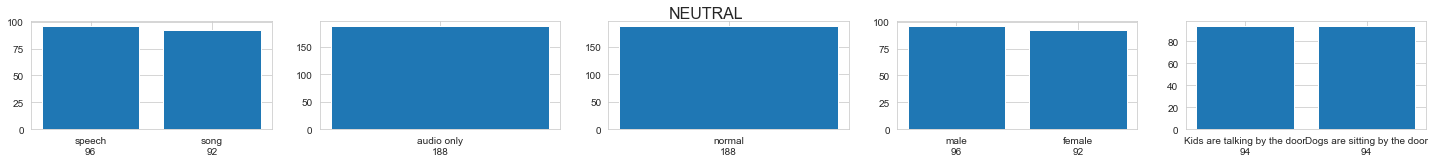

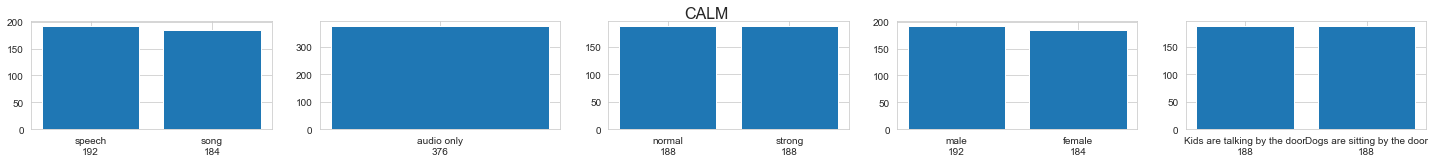

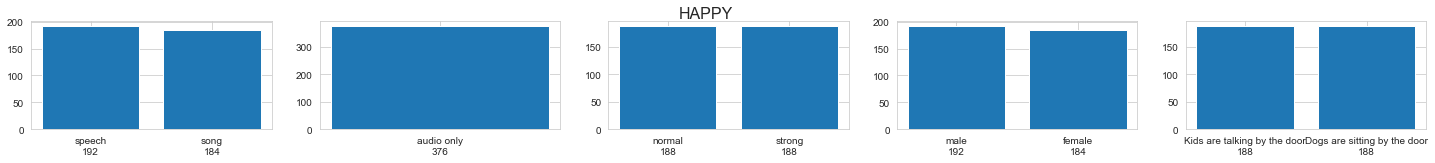

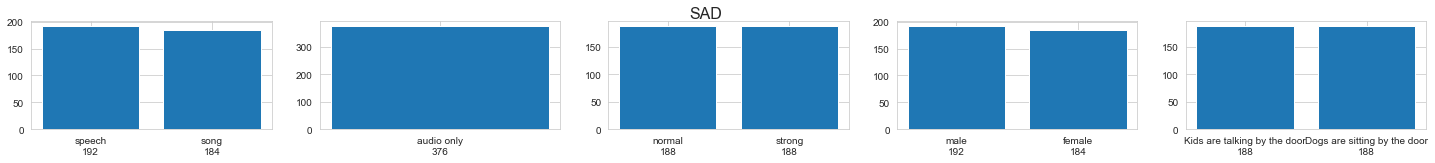

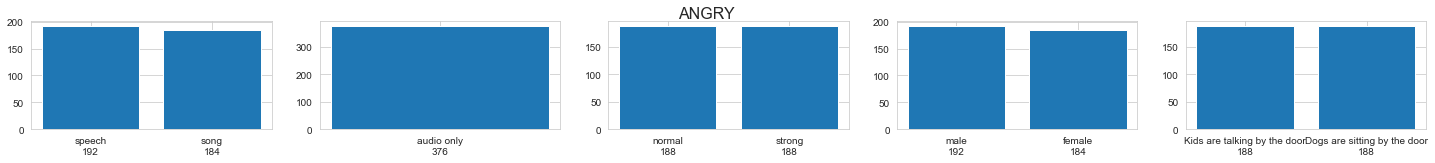

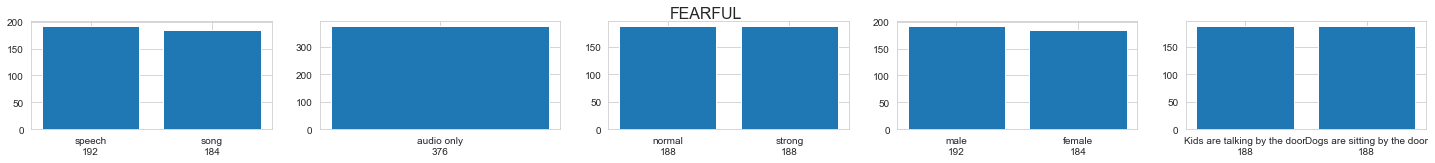

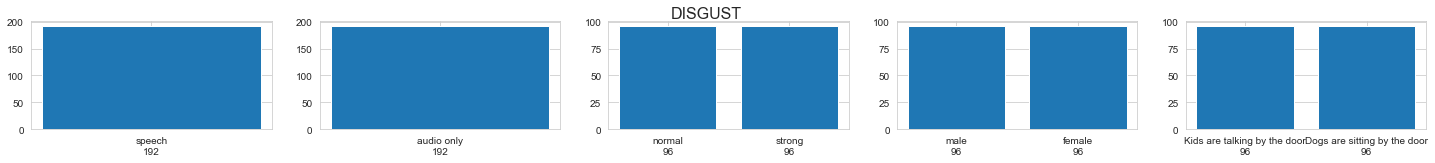

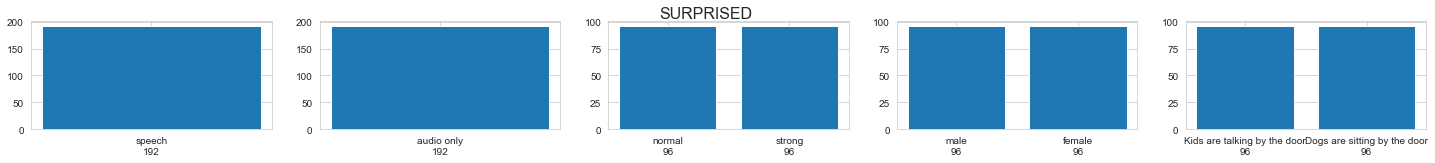

In [ ]:
for emotion_ in emotions_list:
    pdata = df.loc[df.emotion == emotion_]
    fig, axs = plt.subplots(1, 5, figsize=(25, 2))
    fig.suptitle(emotion_.upper(), size=16)
    for i, col in enumerate(['voc_channel', 'modality', 'intensity', 'actors', 'phrase']):
        names= pdata[col].value_counts().index
        values= pdata[col].value_counts().values
        names = [n[0]+'\n'+str(n[1]) for n in zip(names,values)]
        axs[i].bar(names, values)


In [ ]:
df_m = df[['emotion', 'voc_channel', 'intensity', 'actors', 'phrase', 'path']]
df_m = df_m.loc[(df.voc_channel == 'speech') & (df.actors == 'male')]
df_m = df_m.drop(['voc_channel', 'actors'], axis=1)
df_m.head()

,emotion,intensity,phrase,path
0,neutral,normal,Kids are talking by the door,D://ITC//final_project//data\data\Actor_01\03-...
1,neutral,normal,Kids are talking by the door,D://ITC//final_project//data\data\Actor_01\03-...
2,neutral,normal,Dogs are sitting by the door,D://ITC//final_project//data\data\Actor_01\03-...
3,neutral,normal,Dogs are sitting by the door,D://ITC//final_project//data\data\Actor_01\03-...
4,calm,normal,Kids are talking by the door,D://ITC//final_project//data\data\Actor_01\03-...


In [ ]:
def plot_speech(fname, ind, axis):
    # use the Librosa library to load and plot the random speech
    data, sampling_rate = librosa.load(fname)
    plt.figure(figsize=(15, 5))
    librosa.display.waveplot(data, sr=sampling_rate, alpha=.2, ax = axis);

In [1]:
# fig, ax = plt.subplots(len(emotions_list), 1, figsize=(15, 10))
# for n, emotion_ in enumerate(emotions_list):
#     pdata = df_m.loc[df_m.emotion == emotion_]
#     for i, speech_file in enumerate(pdata.path.values[:20]):
#         plot_speech(speech_file, i, ax[n])
#     ax[n].set_title(emotion_.upper(), size=16)
# plt.show();
# plt.savefig('emotions.png');

## Random sample

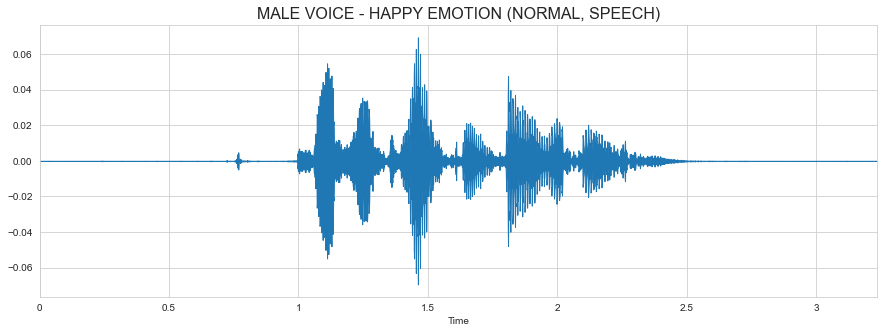

In [ ]:
# choose random number
rnd = np.random.randint(0,n_files)

# use the Librosa library to load and plot the random speech
fname = paths[rnd][0] + '\\' + paths[rnd][1]
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
info = df.iloc[rnd].values
title_txt = f'{info[4]} voice - {info[0]} emotion ({info[3]}, {info[1]})'
plt.title(title_txt.upper(), size=16)
librosa.display.waveplot(data, sr=sampling_rate)

# play the audio
ipd.Audio(fname)

### Make all of the signals the same length:

In [ ]:
lst = np.array(lst)
X, sr = zip(*lst)
X = pd.Series(X)
sr = pd.Series(sr)
y = pd.Series(y)

<ipython-input-242-4a13ceebc0b8>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  lst = np.array(lst)


In [ ]:
sr.unique()
sr = 22050

In [ ]:
lengths = [len(x) for x in X]

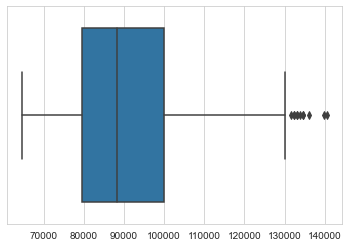

In [ ]:
sns.boxplot(lengths)
plt.show()

12


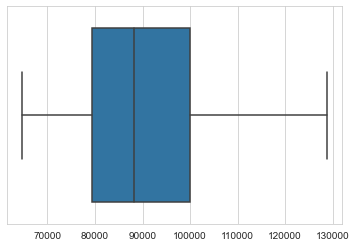

In [ ]:
lengths = np.array(lengths)
print((lengths > 130000).sum())
new_lengths = lengths[lengths < 130000]

sns.boxplot(new_lengths)
plt.show()

In [ ]:
print(new_lengths.mean())
length_chosen = 90000

90015.25860655737


In [ ]:
new_x = []
new_y = []
for ind,i in enumerate(X):
    if i.shape[0] < 130000:
        if i.shape[0] > length_chosen:
            new = i[:length_chosen]
            new_x.append(new)
        elif i.shape[0] < length_chosen:
            new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
            new_x.append(new)
        else:
            new_x.append(i)

        new_y.append(y[ind])


In [ ]:
new_x = np.array(new_x)
new_y = np.array(new_y)
print(new_x.shape, new_y.shape)

(2440,) (2440,)


<ipython-input-250-d69d9639cddf>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  new_x = np.array(new_x)


In [ ]:
mfccs = []
for i in tqdm(new_x):
    mfcc = librosa.feature.mfcc(y=i, sr=sr)
    mfcc = mfcc.T
    mfccs.append(mfcc)


  0%|          | 0/2440 [00:00<?, ?it/s]

In [ ]:
mfccs = np.array(mfccs)
mfccs.shape

(2440, 176, 20)

### Save data

In [ ]:
import pickle


# with open('d://downloads//y.pickle', 'wb') as f:
#     pickle.dump(new_y, f)

# with open('d://downloads//mfccs.pickle', 'wb') as f:
#     pickle.dump(mfccs, f)

with open('d://downloads//mfccs.pickle', 'rb') as f:
    mfccs = pickle.load(f)

with open('d://downloads//y.pickle', 'rb') as f:
    new_y = pickle.load(f)

In [ ]:
mfccs.shape, new_y.shape

((2440, 176, 20), (2440,))

In [ ]:
set(new_y)

{0, 1, 2, 3, 4, 5, 6, 7}

In [ ]:
# random:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mfccs, new_y, test_size=0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1952, 176, 20), (488, 176, 20), (1952,), (488,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

model = Sequential(
    [
     layers.Conv1D(64, 3, activation='relu', input_shape=(176,20)),
     layers.MaxPooling1D(),
     layers.Conv1D(64, 3, activation='relu'),
     layers.MaxPooling1D(),
     layers.Conv1D(64, 3, activation='relu'),
     layers.MaxPooling1D(),
     layers.Flatten(),
     layers.Dense(64, activation="relu"),
     layers.Dense(8, activation="softmax")
    ]
)


In [ ]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 174, 64)           3904      
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 87, 64)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 85, 64)            12352     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 42, 64)            0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 40, 64)            12352     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 20, 64)            0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 1280)            

In [ ]:
model.input_shape, model.output_shape

((None, 176, 20), (None, 8))

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')
model.fit(X_train, y_train, batch_size=16, epochs=200, validation_data=(X_test, y_test))

Epoch 1/200
122/122 [==============================] - 19s 122ms/step - loss: 8.4936 - accuracy: 0.1839 - val_loss: 1.8878 - val_accuracy: 0.2705
Epoch 2/200
122/122 [==============================] - 2s 17ms/step - loss: 1.6898 - accuracy: 0.3590 - val_loss: 1.8322 - val_accuracy: 0.2705
Epoch 3/200
122/122 [==============================] - 2s 16ms/step - loss: 1.5150 - accuracy: 0.4322 - val_loss: 1.6424 - val_accuracy: 0.3770
Epoch 4/200
122/122 [==============================] - 2s 16ms/step - loss: 1.2975 - accuracy: 0.5092 - val_loss: 1.4877 - val_accuracy: 0.4385
Epoch 5/200
122/122 [==============================] - 2s 16ms/step - loss: 1.1830 - accuracy: 0.5570 - val_loss: 1.2594 - val_accuracy: 0.5246
Epoch 6/200
122/122 [==============================] - 2s 16ms/step - loss: 0.9931 - accuracy: 0.6281 - val_loss: 1.4073 - val_accuracy: 0.4980
Epoch 7/200
122/122 [==============================] - 2s 15ms/step - loss: 0.8782 - accuracy: 0.6766 - val_loss: 1.2299 - val_accurac

In [ ]:
import tensorflow as tf

model2 = Sequential()

model2.add(layers.Conv1D(64, 3,padding='same',
                 input_shape=(176,20)))
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(0.1))
model2.add(layers.MaxPooling1D(pool_size=(8)))
model2.add(layers.Conv1D(64, 3,padding='same',))
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(0.1))
model2.add(layers.Flatten())
model2.add(layers.Dense(8))
model2.add(layers.Activation('softmax'))

model2.summary()


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 176, 64)           3904      
_________________________________________________________________
activation_24 (Activation)   (None, 176, 64)           0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 176, 64)           0         
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 22, 64)            0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 22, 64)            12352     
_________________________________________________________________
activation_25 (Activation)   (None, 22, 64)            0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 22, 64)          

In [ ]:
model2.input_shape, model2.output_shape

((None, 176, 20), (None, 8))

In [ ]:

model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model2.fit(X_train, y_train, batch_size=16, epochs=200, validation_data=(X_test, y_test))

Epoch 1/200
122/122 [==============================] - 2s 12ms/step - loss: 26.9364 - accuracy: 0.1797 - val_loss: 1.9643 - val_accuracy: 0.2070
Epoch 2/200
122/122 [==============================] - 1s 9ms/step - loss: 1.8841 - accuracy: 0.2818 - val_loss: 1.7175 - val_accuracy: 0.2889
Epoch 3/200
122/122 [==============================] - 1s 9ms/step - loss: 1.6572 - accuracy: 0.3397 - val_loss: 1.6680 - val_accuracy: 0.3545
Epoch 4/200
122/122 [==============================] - 1s 9ms/step - loss: 1.6237 - accuracy: 0.3694 - val_loss: 1.5487 - val_accuracy: 0.3484
Epoch 5/200
122/122 [==============================] - 1s 9ms/step - loss: 1.4430 - accuracy: 0.4479 - val_loss: 1.6454 - val_accuracy: 0.3586
Epoch 6/200
122/122 [==============================] - 1s 10ms/step - loss: 1.4708 - accuracy: 0.4310 - val_loss: 1.5562 - val_accuracy: 0.4139
Epoch 7/200
122/122 [==============================] - 1s 9ms/step - loss: 1.3543 - accuracy: 0.4801 - val_loss: 1.3960 - val_accuracy: 0.4

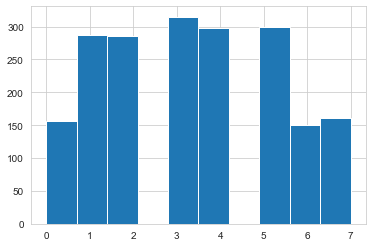

In [ ]:
plt.hist(y_train)
plt.show()

In [ ]:
new_y[:20]

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int64)

In [ ]:
y_less = []
new_mfccs = []
for ind, i in enumerate(new_y):
    if i != 0 and i != 6 and i != 7:
            y_less.append(i)
            new_mfccs.append(mfccs[ind])

y_less = np.array(y_less)
new_mfccs = np.array(new_mfccs)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_mfccs, y_less, test_size=0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1494, 176, 20), (374, 176, 20), (1494,), (374,))

In [ ]:
model = Sequential(
    [
     layers.Conv1D(64, 3, activation='relu', input_shape=(176,20)),
     layers.MaxPooling1D(),
     layers.Conv1D(64, 3, activation='relu'),
     layers.MaxPooling1D(),
     layers.Conv1D(64, 3, activation='relu'),
     layers.MaxPooling1D(),
     layers.Flatten(),
     layers.Dense(64, activation="relu"),
     layers.Dense(8, activation="softmax")
    ]
)


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')
model.fit(X_train, y_train, batch_size=16, epochs=200, validation_data=(X_test, y_test))

Epoch 1/200
94/94 [==============================] - 3s 23ms/step - loss: 16.7817 - accuracy: 0.2649 - val_loss: 1.3625 - val_accuracy: 0.4064
Epoch 2/200
94/94 [==============================] - 2s 18ms/step - loss: 1.2556 - accuracy: 0.4799 - val_loss: 1.2547 - val_accuracy: 0.4385
Epoch 3/200
94/94 [==============================] - 1s 15ms/step - loss: 1.1331 - accuracy: 0.5121 - val_loss: 1.0862 - val_accuracy: 0.5455
Epoch 4/200
94/94 [==============================] - 2s 16ms/step - loss: 0.9056 - accuracy: 0.6238 - val_loss: 1.1450 - val_accuracy: 0.5348
Epoch 5/200
94/94 [==============================] - 1s 15ms/step - loss: 0.8921 - accuracy: 0.6254 - val_loss: 1.0790 - val_accuracy: 0.5481
Epoch 6/200
94/94 [==============================] - 1s 15ms/step - loss: 0.6697 - accuracy: 0.7390 - val_loss: 0.9609 - val_accuracy: 0.6283
Epoch 7/200
94/94 [==============================] - 1s 16ms/step - loss: 0.6516 - accuracy: 0.7457 - val_loss: 1.0167 - val_accuracy: 0.6417
Epoch

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf

model2 = Sequential()

model2.add(layers.Conv1D(64, 3,padding='same',
                 input_shape=(176,20)))
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(0.1))
model2.add(layers.MaxPooling1D(pool_size=(8)))
model2.add(layers.Conv1D(64, 3,padding='same',))
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(0.1))
model2.add(layers.Flatten())
model2.add(layers.Dense(8))
model2.add(layers.Activation('softmax'))

model2.summary()


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_39 (Conv1D)           (None, 176, 64)           3904      
_________________________________________________________________
activation_27 (Activation)   (None, 176, 64)           0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 176, 64)           0         
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 22, 64)            0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 22, 64)            12352     
_________________________________________________________________
activation_28 (Activation)   (None, 22, 64)            0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 22, 64)          

In [ ]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')
model2.fit(X_train, y_train, batch_size=16, epochs=200, validation_data=(X_test, y_test))

Epoch 1/200
94/94 [==============================] - 2s 14ms/step - loss: 28.4027 - accuracy: 0.2553 - val_loss: 2.0528 - val_accuracy: 0.3182
Epoch 2/200
94/94 [==============================] - 1s 12ms/step - loss: 1.8886 - accuracy: 0.3588 - val_loss: 1.4572 - val_accuracy: 0.3824
Epoch 3/200
94/94 [==============================] - 1s 11ms/step - loss: 1.3257 - accuracy: 0.4305 - val_loss: 1.2566 - val_accuracy: 0.3904
Epoch 4/200
94/94 [==============================] - 1s 11ms/step - loss: 1.2470 - accuracy: 0.4456 - val_loss: 1.2459 - val_accuracy: 0.4412
Epoch 5/200
94/94 [==============================] - 1s 12ms/step - loss: 1.1517 - accuracy: 0.4950 - val_loss: 1.1904 - val_accuracy: 0.4572
Epoch 6/200
94/94 [==============================] - 1s 11ms/step - loss: 1.0972 - accuracy: 0.5159 - val_loss: 1.1493 - val_accuracy: 0.4866
Epoch 7/200
94/94 [==============================] - 1s 10ms/step - loss: 1.0616 - accuracy: 0.5334 - val_loss: 1.3311 - val_accuracy: 0.4011
Epoch

In [ ]:
import tensorflow as tf

model3 = Sequential()

model3.add(layers.Conv1D(256, 5,padding='same',
                 input_shape=(176,20)))
model3.add(layers.Activation('relu'))
model3.add(layers.Dropout(0.1))
model3.add(layers.MaxPooling1D(pool_size=(8)))

model3.add(layers.Conv1D(128, 5,padding='same',))
model3.add(layers.Activation('relu'))
model3.add(layers.Dropout(0.1))

model3.add(layers.Conv1D(64, 5,padding='same',))
model3.add(layers.Activation('relu'))
model3.add(layers.Dropout(0.1))
model3.add(layers.MaxPooling1D(pool_size=(8)))

model3.add(layers.Conv1D(32, 5,padding='same',))
model3.add(layers.Activation('relu'))
model3.add(layers.Dropout(0.1))

model3.add(layers.Flatten())
model3.add(layers.Dense(8))
model3.add(layers.Activation('softmax'))

model3.summary()


Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_41 (Conv1D)           (None, 176, 256)          25856     
_________________________________________________________________
activation_30 (Activation)   (None, 176, 256)          0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 176, 256)          0         
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 22, 256)           0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 22, 128)           163968    
_________________________________________________________________
activation_31 (Activation)   (None, 22, 128)           0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 22, 128)         

In [ ]:
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')
model3.fit(X_train, y_train, batch_size=8, epochs=200, validation_data=(X_test, y_test))

Epoch 1/200
187/187 [==============================] - 6s 27ms/step - loss: 7.9959 - accuracy: 0.2122 - val_loss: 1.4319 - val_accuracy: 0.3128
Epoch 2/200
187/187 [==============================] - 5s 24ms/step - loss: 1.4136 - accuracy: 0.3621 - val_loss: 1.3845 - val_accuracy: 0.3369
Epoch 3/200
187/187 [==============================] - 5s 24ms/step - loss: 1.3560 - accuracy: 0.3479 - val_loss: 1.2246 - val_accuracy: 0.4626
Epoch 4/200
187/187 [==============================] - 5s 25ms/step - loss: 1.3019 - accuracy: 0.3820 - val_loss: 1.2231 - val_accuracy: 0.4439
Epoch 5/200
187/187 [==============================] - 5s 26ms/step - loss: 1.2343 - accuracy: 0.4406 - val_loss: 1.2061 - val_accuracy: 0.4332
Epoch 6/200
187/187 [==============================] - 5s 24ms/step - loss: 1.2045 - accuracy: 0.4273 - val_loss: 1.1839 - val_accuracy: 0.4545
Epoch 7/200
187/187 [==============================] - 5s 25ms/step - loss: 1.2136 - accuracy: 0.4543 - val_loss: 1.1736 - val_accuracy:

## Binary classification-  Classifaying positive VS negetive emotions:

In [ ]:
new_y.shape, mfccs.shape

((2440,), (2440, 176, 20))

In [ ]:
new_y = pd.Series(new_y).map(lambda x:0 if x in [0,1,2,3] else 1)

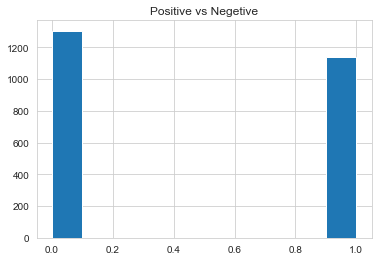

In [ ]:
plt.title('Positive vs Negetive')
plt.hist(new_y)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(mfccs, new_y, test_size=0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1952, 176, 20), (488, 176, 20), (1952,), (488,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

model_binary = Sequential(
    [
     layers.Conv1D(64, 3, activation='relu', input_shape=(176,20)),
     layers.MaxPooling1D(),
     layers.Conv1D(64, 3, activation='relu'),
     layers.MaxPooling1D(),
     layers.Conv1D(64, 3, activation='relu'),
     layers.MaxPooling1D(),
     layers.Flatten(),
     layers.Dense(64, activation="relu"),
     layers.Dense(1, activation="sigmoid")
    ]
)

model_binary.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 174, 64)           3904      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 87, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 85, 64)            12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 42, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 40, 64)            12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 20, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0

In [ ]:
model_binary.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model_binary.fit(X_train, y_train, batch_size=16, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
122/122 [==============================] - 2s 10ms/step - loss: 0.0559 - accuracy: 0.9818 - val_loss: 1.0479 - val_accuracy: 0.8299
Epoch 2/5
122/122 [==============================] - 1s 8ms/step - loss: 0.1170 - accuracy: 0.9678 - val_loss: 0.8355 - val_accuracy: 0.8484
Epoch 3/5
122/122 [==============================] - 1s 9ms/step - loss: 0.0550 - accuracy: 0.9780 - val_loss: 0.7246 - val_accuracy: 0.8443
Epoch 4/5
122/122 [==============================] - 1s 8ms/step - loss: 0.0134 - accuracy: 0.9947 - val_loss: 0.9152 - val_accuracy: 0.8402
Epoch 5/5
122/122 [==============================] - 1s 8ms/step - loss: 0.0421 - accuracy: 0.9859 - val_loss: 0.5777 - val_accuracy: 0.8463


In [ ]:
import tensorflow as tf

model_binary2 = Sequential()

model_binary2.add(layers.Conv1D(256, 5,padding='same',
                 input_shape=(176,20)))
model_binary2.add(layers.Activation('relu'))
model_binary2.add(layers.Dropout(0.1))
model_binary2.add(layers.MaxPooling1D(pool_size=(8)))

model_binary2.add(layers.Conv1D(128, 5,padding='same',))
model_binary2.add(layers.Activation('relu'))
model_binary2.add(layers.Dropout(0.1))

model_binary2.add(layers.Conv1D(64, 5,padding='same',))
model_binary2.add(layers.Activation('relu'))
model_binary2.add(layers.Dropout(0.1))
model_binary2.add(layers.MaxPooling1D(pool_size=(8)))

model_binary2.add(layers.Conv1D(32, 5,padding='same',))
model_binary2.add(layers.Activation('relu'))
model_binary2.add(layers.Dropout(0.1))

model_binary2.add(layers.Flatten())
model_binary2.add(layers.Dense(1))
model_binary2.add(layers.Activation('sigmoid'))

model_binary2.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 176, 256)          25856     
_________________________________________________________________
activation (Activation)      (None, 176, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 176, 256)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 22, 256)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 22, 128)           163968    
_________________________________________________________________
activation_1 (Activation)    (None, 22, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 128)          

In [ ]:
model_binary2.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model_binary2.fit(X_train, y_train, batch_size=16, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
122/122 [==============================] - 4s 26ms/step - loss: 0.0232 - accuracy: 0.9942 - val_loss: 0.5217 - val_accuracy: 0.8791
Epoch 2/5
122/122 [==============================] - 3s 23ms/step - loss: 0.0097 - accuracy: 0.9982 - val_loss: 0.3477 - val_accuracy: 0.8770
Epoch 3/5
122/122 [==============================] - 3s 24ms/step - loss: 0.0215 - accuracy: 0.9930 - val_loss: 0.4849 - val_accuracy: 0.8811
Epoch 4/5
122/122 [==============================] - 3s 23ms/step - loss: 0.0143 - accuracy: 0.9963 - val_loss: 0.8304 - val_accuracy: 0.8852
Epoch 5/5
122/122 [==============================] - 3s 24ms/step - loss: 0.0140 - accuracy: 0.9928 - val_loss: 0.7127 - val_accuracy: 0.8873
